### Import libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# To avoid annoying warnings
import warnings
warnings.filterwarnings('ignore')

from scipy import stats

# Sklearn modules
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

# Graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns

### Data load

In [2]:
file = pd.read_csv('fifa21_trainning.csv')
data_original = pd.DataFrame(file)
data = data_original.copy()
data.head()

,Unnamed: 0,ID,Name,Age,Nationality,Club,BP,Position,Team & Contract,Height,...,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,OVA
0,1954,184383,A. Pasche,26,Switzerland,FC Lausanne-Sport,CM,CM CDM,FC Lausanne-Sport 2015 ~ 2020,"5'9""",...,59+1,59+1,59+1,58+1,54+1,54+1,54+1,58+1,15+1,64
1,2225,188044,Alan Carvalho,30,China PR,Beijing Sinobo Guoan FC,ST,ST LW LM,"Beijing Sinobo Guoan FC Dec 31, 2020 On Loan","6'0""",...,53+2,53+2,57+2,53+2,48+2,48+2,48+2,53+2,18+2,77
2,1959,184431,S. Giovinco,33,Italy,Al Hilal,CAM,CAM CF,Al Hilal 2019 ~ 2022,"5'4""",...,56+2,56+2,59+2,53+2,41+2,41+2,41+2,53+2,12+2,80
3,9815,233796,J. Evans,22,Wales,Swansea City,CDM,CDM CM,Swansea City 2016 ~ 2021,"5'10""",...,58+2,58+2,56+2,57+2,58+2,58+2,58+2,57+2,14+2,59
4,10074,234799,Y. Demoncy,23,France,US Orléans Loiret Football,CDM,CDM CM,US Orléans Loiret Football 2018 ~ 2021,"5'11""",...,64+2,64+2,64+2,63+2,61+2,61+2,61+2,63+2,15+2,65


In [3]:
data.shape

(13700, 102)

### Data cleaning

In [4]:
# 'Unnamed:0' and 'ID' are not relevant, so I drop them

data = data.drop('Unnamed: 0', axis=1)
data = data.drop('ID', axis=1)

In [5]:
data.columns = data.columns.str.lower().str.replace(' ','_')

In [6]:
# Function to clean the columns with €, K and M
def fix_n(arg):
    v = str(arg)
    v = float(v.replace('€', '').replace('K', '').replace('M', ''))
    m = str(arg)
    m = m.replace('€', '')
    if 'K' in m:
        m = 1000
    elif 'M' in m:
        m = 1000000
    else:
        m = 1
    return v*m    

In [7]:
# Function to clean the columns with numbers and + signs
def my_adding_fct(arg):
    if '+' in arg:
        l = arg.split('+')
    l = [int(i) for i in l]
    return sum(l)

In [8]:
# Columns with financial data
moneycols = ['value', 'wage', 'release_clause']

# Columns with data formatted as number+number
nplusn = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']

In [9]:
# The main numerical dataset
data_num = data[data.select_dtypes(include=np.number).columns.to_list() + nplusn + moneycols]
data_num.head()

,age,growth,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,...,rwb,lb,lcb,cb,rcb,rb,gk,value,wage,release_clause
0,26,1,258,54,47,43,70,44.0,286,61,...,59+1,58+1,54+1,54+1,54+1,58+1,15+1,€525K,€4K,€801K
1,30,0,365,66,79,76,68,76.0,375,83,...,57+2,53+2,48+2,48+2,48+2,53+2,18+2,€8.5M,€23K,€0
2,33,0,336,73,76,34,78,75.0,424,85,...,59+2,53+2,41+2,41+2,41+2,53+2,12+2,€9M,€49K,€15.3M
3,22,13,242,44,42,58,62,36.0,259,54,...,56+2,57+2,58+2,58+2,58+2,57+2,14+2,€275K,€4K,€694K
4,23,8,249,49,37,61,68,34.0,280,64,...,64+2,63+2,61+2,61+2,61+2,63+2,15+2,€725K,€2K,€1.4M


In [10]:
# Gets numbers from financial data
for i in range(len(moneycols)):
    data_num[moneycols[i]+'_'] = data_num[moneycols[i]].apply(fix_n)
    data_num = data_num.drop(moneycols[i], axis=1)

In [11]:
# Gets numbers from data formatted as number+number
for i in range(len(nplusn)):
    data_num[nplusn[i]+'_'] = data_num[nplusn[i]].apply(my_adding_fct)
    data_num = data_num.drop(nplusn[i], axis=1)

In [12]:
data_num.head()

,age,growth,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,...,ldm_,cdm_,rdm_,rwb_,lb_,lcb_,cb_,rcb_,rb_,gk_
0,26,1,258,54,47,43,70,44.0,286,61,...,60,60,60,60,59,55,55,55,59,16
1,30,0,365,66,79,76,68,76.0,375,83,...,55,55,55,59,55,50,50,50,55,20
2,33,0,336,73,76,34,78,75.0,424,85,...,58,58,58,61,55,43,43,43,55,14
3,22,13,242,44,42,58,62,36.0,259,54,...,60,60,60,58,59,60,60,60,59,16
4,23,8,249,49,37,61,68,34.0,280,64,...,66,66,66,66,65,63,63,63,65,17


In [13]:
# Are there empty values? How many?
print(data_num.isnull().values.any())
print(data_num.isnull().sum().sum())

True
651


In [14]:
# Replaces empty values with zeros
data_num = data_num.replace(np.nan, 0)
data_num.head()

,age,growth,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,...,ldm_,cdm_,rdm_,rwb_,lb_,lcb_,cb_,rcb_,rb_,gk_
0,26,1,258,54,47,43,70,44.0,286,61,...,60,60,60,60,59,55,55,55,59,16
1,30,0,365,66,79,76,68,76.0,375,83,...,55,55,55,59,55,50,50,50,55,20
2,33,0,336,73,76,34,78,75.0,424,85,...,58,58,58,61,55,43,43,43,55,14
3,22,13,242,44,42,58,62,36.0,259,54,...,60,60,60,58,59,60,60,60,59,16
4,23,8,249,49,37,61,68,34.0,280,64,...,66,66,66,66,65,63,63,63,65,17


In [15]:
# Are there empty values? How many?
print(data_num.isnull().values.any())
print(data_num.isnull().sum().sum())

False
0


In [16]:
# Checking higher correlations with target
# Just for reference. I ended up using a different method
c = pd.DataFrame(((data_num.corrwith(data_num['ova']))**2)**.5)
c = c.sort_values(0,ascending=False)
c = c[0:15].T
c

,ova,reactions,base_stats,pas,dri,value_,total_stats,release_clause_,growth,wage_,power,phy,shot_power,rcm_,cm_
0,1.0,0.869824,0.832967,0.700421,0.643046,0.632681,0.604432,0.598741,0.596555,0.586749,0.544295,0.543247,0.535906,0.524624,0.524624


In [17]:
# Checking higher correlations with target
# Method used. A threshold will be set
corrs_keep = (((data_num.corrwith(data_num['ova']))**2)**.5)
corrs_keep

age          0.519422
growth       0.596555
attacking    0.426562
crossing     0.383847
finishing    0.299406
               ...   
lcb_         0.376538
cb_          0.376538
rcb_         0.376538
rb_          0.405986
gk_          0.102044
Length: 82, dtype: float64

In [18]:
# Drops all the columns where the correlations with the target are below a threshold
corrs_drop = []
threshold = 0.6
for i in range(corrs_keep.shape[0]):
    if corrs_keep[i] < threshold:
        corrs_keep[i] = np.nan
        corrs_drop.append(corrs_keep.index[i])
corrs_keep = corrs_keep.dropna()
data_num = data_num.drop(corrs_drop, axis=1)
data_num.head()

,reactions,total_stats,base_stats,pas,dri,ova,value_
0,66,1682,357,63,63,64,525000.0
1,75,1961,412,68,82,77,8500000.0
2,78,1925,404,78,86,80,9000000.0
3,55,1527,329,54,57,59,275000.0
4,62,1664,360,60,64,65,725000.0


In [19]:
# I want 'ova' at the end just for visualisation
col_sorted = data_num.columns.to_list()
col_sorted.remove('ova')
col_sorted.append('ova')
data_num = data_num[col_sorted]

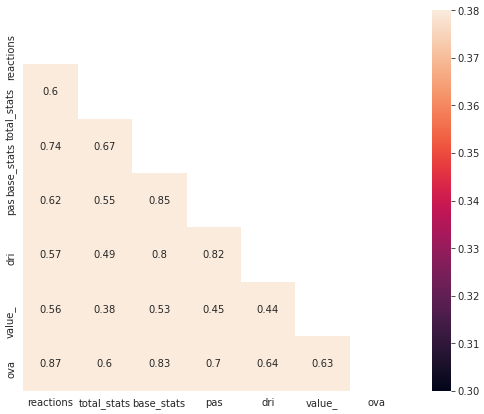

In [20]:
# Visualize the selected columns and its correlations
corr = np.corrcoef(data_num.corr().round(2))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(data_num.corr().round(2), mask=mask, vmax=.3, annot = True, square=True)


### Categoricals

In [21]:
data_cat = data.select_dtypes(include=np.object)
data_cat = data_cat.drop(nplusn, axis=1)
data_cat = data_cat.drop(moneycols, axis=1)
data_cat.head()

,name,nationality,club,bp,position,team_&_contract,height,weight,foot,joined,loan_date_end,contract,w/f,sm,a/w,d/w,ir,hits
0,A. Pasche,Switzerland,FC Lausanne-Sport,CM,CM CDM,FC Lausanne-Sport 2015 ~ 2020,"5'9""",161lbs,Right,"Jul 1, 2015",NaN,2015 ~ 2020,4 ★,2★,High,Medium,1 ★,3
1,Alan Carvalho,China PR,Beijing Sinobo Guoan FC,ST,ST LW LM,"Beijing Sinobo Guoan FC Dec 31, 2020 On Loan","6'0""",159lbs,Right,"Jan 16, 2015","Dec 31, 2020","Dec 31, 2020 On Loan",3 ★,4★,High,Low,2 ★,44
2,S. Giovinco,Italy,Al Hilal,CAM,CAM CF,Al Hilal 2019 ~ 2022,"5'4""",134lbs,Right,"Jan 31, 2019",NaN,2019 ~ 2022,4 ★,4★,High,Medium,2 ★,73
3,J. Evans,Wales,Swansea City,CDM,CDM CM,Swansea City 2016 ~ 2021,"5'10""",152lbs,Right,"Jul 1, 2016",NaN,2016 ~ 2021,2 ★,2★,Medium,Medium,1 ★,7
4,Y. Demoncy,France,US Orléans Loiret Football,CDM,CDM CM,US Orléans Loiret Football 2018 ~ 2021,"5'11""",150lbs,Right,"Jul 1, 2018",NaN,2018 ~ 2021,2 ★,3★,Low,Medium,1 ★,4


### X-Y split

In [22]:
y = data_num['ova']
X = data_num.drop(['ova'], axis=1)

### Normalizing and standardizing

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

standard = StandardScaler()
X_train_scaled = standard.fit_transform(X_train)
X_test_scaled  = standard.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns = X_test.columns)

X_train_scaled.head()

,reactions,total_stats,base_stats,pas,dri,value_
0,0.891700,1.237213,1.259161,1.089513,0.584345,0.095408
1,-0.981795,-0.349800,-0.701406,-0.484801,0.177080,-0.393740
2,-0.430767,0.367408,0.241652,-0.091223,-0.026553,-0.356823
3,0.120261,0.340703,0.067931,0.597540,0.177080,-0.292218
4,-0.320562,0.344518,0.142383,0.203961,-0.128369,-0.389125


### Create linear model

In [24]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
predictions  = lm.predict(X_test)

### Validation

In [25]:
r2 = r2_score(y_test, predictions)
r2

0.8511766888201159

In [26]:
n = len(X_test) 
p = X_test.shape[1]
adj_r2 = 1-((1-r2)*(n-1)/(n-p-1))
adj_r2

0.8509590578508058

In [27]:
mse = mean_squared_error(y_test, predictions)
print(mse)

6.970981345636169


In [28]:
rmse = mse**0.5
print(rmse)

2.6402616055300596
